In [1]:
import numpy as np
from time import time
import os, gzip, shutil, codecs
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from scipy.stats import multivariate_normal as mvn
import pandas as pd

In [2]:
"""
Since this project uses the same mnist data set, we adapted 
the first classification project to extract our data

"""
path_in = os.getcwd()+'/raw_data/'
path_out = os.getcwd()+'/extracted/'

files_in = os.listdir(path_in)
    
for file in files_in:
    if file.endswith('gz'):
        with gzip.open(path_in + file, mode='rb') as f_in:
            with open(path_out + file.split('.')[0], mode='wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
                files_out = os.listdir(path_out)

my_dic = {}
for file1 in files_out:
    if file1.endswith('ubyte'):
        with open(path_out + file1, mode='rb') as f:
            my_data = f.read()
            # file type check
            magic_num = int(codecs.encode(my_data[0:4], 'hex'), 16)
            # file length check
            num_len = int(codecs.encode(my_data[4:8], 'hex'), 16)
            # print(num_len, magic_num)
            # train len: 60000; test len: 10000 
            if num_len == 10000:
                length = 'test'
            elif num_len == 60000:
                length = 'train'
                
            if magic_num == 2049:
                # start from offset 8, convert one label to an integer each time
                lab = np.frombuffer(my_data, np.uint8, offset=8)
                parse = lab.reshape(num_len)
                # print(lab)
                cat = 'label'
            elif magic_num == 2051:
                # rows from offset 8 - 11
                rows = int(codecs.encode(my_data[8:12], 'hex'), 16)
                # colmns from offset 12 - 15
                cols = int(codecs.encode(my_data[12:16], 'hex'), 16)
                # start from offset 16, convert one pixel to an integer each time
                pix = np.frombuffer(my_data, np.uint8, offset=16)
                parse = pix.reshape(num_len, rows, cols)
                cat = 'image'
            
            my_dic[cat + '_' + length] = parse

print(my_dic.keys())
print('image_test shape: ' + str(my_dic['image_test'].shape))
print('label_test shape: ' + str(my_dic['label_test'].shape))
print('image_train shape: ' + str(my_dic['image_train'].shape))
print('label_train shape: ' + str(my_dic['label_train'].shape))
# my_dic['label_test']
X_train, y_train = my_dic['image_train'].reshape(60000, 28*28), my_dic['label_train']
X_test, y_test = my_dic['image_test'].reshape(10000, 28*28), my_dic['label_test']

dict_keys(['image_test', 'label_test', 'image_train', 'label_train'])
image_test shape: (10000, 28, 28)
label_test shape: (10000,)
image_train shape: (60000, 28, 28)
label_train shape: (60000,)


***training and testing data dimentions***

In [3]:
print('X_train shape: ' + str(X_train.shape))
print('X_test shape: ' + str(X_test.shape))
print('y_train shape: ' + str(y_train.shape))
print('y_test shape: ' + str(y_test.shape))

X_train shape: (60000, 784)
X_test shape: (10000, 784)
y_train shape: (60000,)
y_test shape: (10000,)


#### Question 1. 
Since the model for each pixel follows Gaussian distribution, it means the prior probability of each class is the same. That is, $\ P(c=0) = P(c=1) = P(c=2) = ... = P(c=9)$. Then, the proir probablity ends up to be a constant factor and we will not consider this term
for our classifier. Therefore, $\ P(c|x)=\prod_{i=1}^{28 \times28}P(x_i|c)$ is the model we are using, which is the product of each image pixel's probability given the label class from 0 to 9.  

We also have to consider about the smoothing parameter by adding some value k to our model. This is because we cannot guarantee our training data have all the label classes. It might occur that the number of image pixels given the specific label is 0. When it happens, Our result will always return to 0 no matter what. So, adding a smoothing parameter is very important. 

In [4]:
class NaiveBayes():
    
    
    '''no prior terms are considered for our classifier'''
    def fit(self, X, y, smoothing=10e-3):
        self.gaussians = {}
        labels = set(y)
        for c in labels:
            x = X[y == c]
            self.gaussians[c] = {
                'mean': x.mean(axis=0),
                'var': x.var(axis=0) + smoothing
            }
            
        
    def cm_accuracy(self, X, y):
        P = self.predict(X)[0]
        cfm = confusion_matrix(P, y)
        overall_accuracy = round(sum(np.diag(cfm)) / len(y), 5)
        accuracy = []
        for i in range(10):
            a = round(np.diag(cfm)[i] / sum(cfm[i]), 5)
            accuracy.append(a)
        return (cfm, overall_accuracy, accuracy)
    
    
    def predict(self, X):
        N, D = X.shape
        K = len(self.gaussians)
        P = np.zeros((N, K))
        mean_list = []
        var_list = []
        # prediction        
        for c , g in self.gaussians.items():
            mean, var = g['mean'], g['var']
            mean_list.append(mean)
            var_list.append(var)
            P[:, c] = mvn.logpdf(X, mean = mean, cov = var)
            np.argmax(P, axis=1)
        return np.argmax(P, axis=1), np.argmax(P, axis=0), mean_list, var_list
    
    


    

    def pred_real_plt(self, X):
        tmp = self.predict(X)[0]
        iterate = 0
        '''
        We can cutomize the number of test time to observe the accuracy of the conditional 
        probability intuitively. We used the range of 4 in this case
        
        '''
        for i in range(4):
            labels = ["P(x|c="+str(tmp[0+iterate])+")", 
                      "P(x|c="+str(tmp[1+iterate])+")", 
                      "P(x|c="+str(tmp[2+iterate])+")",
                      "P(x|c="+str(tmp[3+iterate])+")", 
                      "P(x|c="+str(tmp[4+iterate])+")", 
                      "P(x|c="+str(tmp[5+iterate])+")", 
                      "P(x|c="+str(tmp[6+iterate])+")", 
                      "P(x|c="+str(tmp[7+iterate])+")", 
                      "P(x|c="+str(tmp[8+iterate])+")", 
                      "P(x|c="+str(tmp[9+iterate])+")"]
            plt.subplots(figsize=(20, 5))
            for y, cls in enumerate(labels):
                plt.subplot(1, len(labels), y + 1)
                plt.imshow(X[y+iterate].reshape((28, 28)), cmap='gray')
                plt.title(cls)
                plt.axis("off")
            '''
            as long as the iteration is the factor of 10, we can secure the prediction value 
            '''
            iterate += 300
            
    
if __name__ == '__main__':
    model = NaiveBayes()
    print('Number of training set used: ' + str(len(y_train)))
    t0 = time()
    model.fit(X_train, y_train)
    print('NaiveBayes model training time: ', round(time() - t0, 3), 's')
    print("Overall train confusion matrix: \n", model.cm_accuracy(X_train, y_train)[0])
    t0 = time()
    print("Overall train accuracy: ", model.cm_accuracy(X_train, y_train)[1])
    print("Time spent in overall train accuracy: ", round(time() - t0, 3), 's')
    t0 = time()
    print("Each label's train accuracy: ", pd.DataFrame(model.cm_accuracy(X_train, y_train)[2], columns=[" "]))
    print("Time spent for each train accuracy: ", round(time() - t0, 3), 's')
    
    print('==============================================================')
    
    print('Number of test set used: ' + str(len(y_test)))
    print("Overall test confusion matrix: \n", model.cm_accuracy(X_test, y_test)[0])
    t0 = time()
    print("Overall test accuracy : ", model.cm_accuracy(X_test, y_test)[1])
    print("Time spent in overall test accuracy: ", round(time() - t0, 3), 's')
    t0 = time()
    print("Each label's test accuracy: ", pd.DataFrame(model.cm_accuracy(X_test, y_test)[2], columns=[" "]))
    print("Time for in each test accuracy: ", round(time() - t0, 3), 's')


Number of training set used: 60000
NaiveBayes model training time:  0.285 s
Overall train confusion matrix: 
 [[5274    1  325  191   75  493   52   29   83   29]
 [  12 6374  171  341   59  149  120   49  848   59]
 [  48   22 2505   84   64   44   40   14   38   17]
 [  16   42  397 3114   29  197    2   60   75    8]
 [  12    3   37   21 1615   61    4   76   33   74]
 [  19   16   31   27   49  662   30    8   56    5]
 [ 154   66 1194  200  406  250 5528   13   76    4]
 [   5    4   18   56   22   16    0 2425    7  109]
 [ 300  151 1208 1585  974 3086  134  150 3844  110]
 [  83   63   72  512 2549  463    8 3441  791 5534]]
Overall train accuracy:  0.61458
Time spent in overall train accuracy:  5.337 s
Each label's train accuracy:            
0  0.80495
1  0.77903
2  0.87100
3  0.79036
4  0.83419
5  0.73311
6  0.70054
7  0.91097
8  0.33304
9  0.40944
Time spent for each train accuracy:  5.6 s
Number of test set used: 10000
Overall test confusion matrix: 
 [[ 880    0   51   23

The overall accuracy seems low, with only ~61% in this classifier. However, the individual label accuracy seems high except digits 8 and 9. I assume the reason of the high individual label accuracy is because each digit have different sample size. 

model.predict() function predicts each digit's label pixel by pixel (784 pixels), then it returns the most likely digit for the result by applying multivariant normal distribution probability density function. This result is going to compare with the true labels from the testing data set below.

In [5]:
model.predict(X_test)[0]

array([9, 2, 1, ..., 9, 8, 6])

y_test is a set of truth labels.

In [6]:
y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

The image results using conditional probability for each pixel to classify labels are shown below. By using this classifier, we are able to use each of those image to compare with all 0s, 1s, ... in the testing data set. If the majority of the pixels on the testing data set are hitting the one of these classifier, it will classify that as a corresbonding class label. 

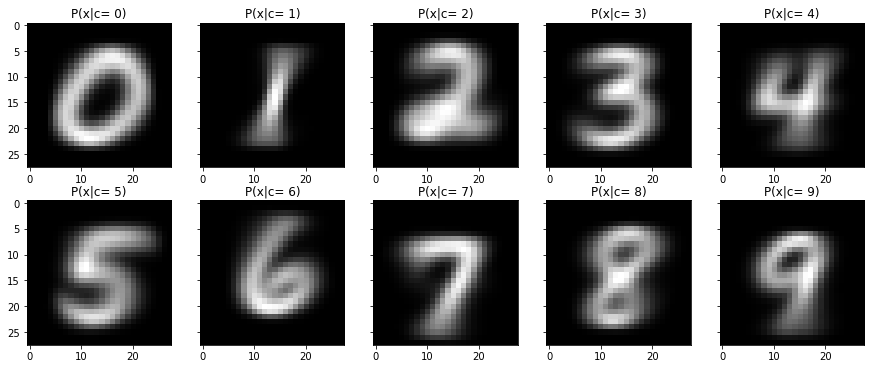

In [7]:
w_mean = model.predict(X_test)[2]

f, axs = plt.subplots(2, 5,figsize=(15, 6), sharey=True)
axs = axs.ravel()
for i in range(len(w_mean)):
    axs[i].imshow(w_mean[i].reshape(28,28),cmap=plt.cm.gray)
    axs[i].set_title('P(x|c= %s'%i+")")


For each digit we are comparing below, it seems like the classifier is easily to be tricked to predict 8 and 9 with a 7. It might be the cause of people's writing habbits. For instance, from the 2nd row 2nd column and 8th column, both of them are digit 7; but some people would like to add a little bar on this digit, and therefore it somehow confuses the classifier to make the right choice. Digit 1 and 0 seems fine from these images and it makes sense because our test accuracy for 1 and 0 are relatively high. 

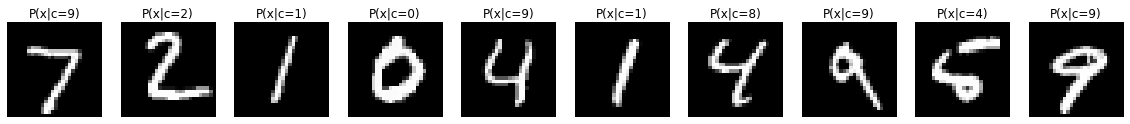

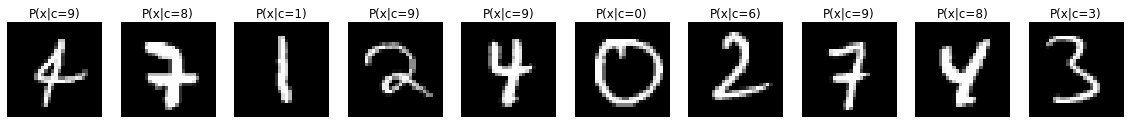

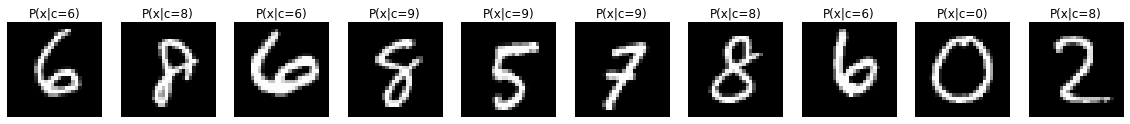

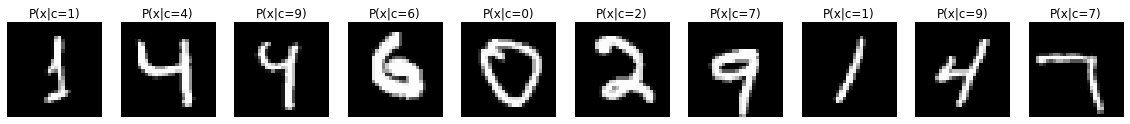

In [8]:
model.pred_real_plt(X_test)

Part 2. (60 points) Build a regularized logistic regression classiﬁer, where you use ridge (2) regularization. Test this classiﬁer on the MNIST data set by developing 10 classiﬁers: 0 versus all, 1 versus all, 2 versus all, ... , 9 versus all. Provide a confusion matrix, accuracy for each digit, and overall accuracy. Plot the overall test accuracy versus the regularization value where a log-scale is used for regularization value. Essentially, the ‘1 versus all’ classiﬁer is trained to give you a probability of the digit 1 versus all other digits. Hence, digit 1 is class +1 and all other digits are class -1. Hence, to classify a test image, you take the maximum probability from all 10 classiﬁers, giving the predicted class of the input image. 2 regularized logistic regression uses the following log-likelihood,
L(w) =
N X i=1
log(1 + exp(−yiwTxi)) + λ 2kwk2. Recall, that by taking the gradient of L(w), we obtained the following gradient descent update equation for (non-regularized) logistic regression, wt+1 = wt −ηt∇L(w), where ∇L(w) = N X i=1 −yixi exp(−yiwTxi) 1 + exp(−yiwTxi) . Derive the update equation for the regularized logistic regression and present your derivation. Apply that classiﬁer to the MNIST data set. Don’t forget to add a column of 1s to your 784-length feature vector (the image values) so that you get the bias term with your classiﬁer. For each of your 10 trained classiﬁers, show an image of the 784 weights (don’t show the bias weight) as a 28 × 28 image. Do these images provide any insight to how this classiﬁer works? 

In [9]:
class LogisticRegression(object):
    
    
    def sigmoid(self, signal):
        '''
        The sigmoid is a function that has the equation 1/(1+e^-x).
        The sigmoid is used within the function for both the computation and final
        prediction of the algorithm. We will treat P(y|x) = sigmoid(y * w.T * x)
        '''
        return 1/(1 + np.exp(-signal))


    def gradient(self, features,labels, lam, weight,learn_rate):
        #Simplifys the step of matrix multiplication
        feature_label = np.multiply(features,labels.reshape(-1,1))  #X*y
        features_weight = np.dot(features,weight)  #X*w.T
        
        #Calculates class error then multiplys through by XY
        class_error = (1 - self.sigmoid(np.multiply(features_weight,labels))).reshape(-1,1)  #1 - Probability(y|x)
        grade = np.multiply(feature_label,class_error)  #XY ( 1-Probability(y|x))
        return learn_rate * (-sum(grade) + lam*weight)   #n * (-sum(xy(1-p(y|x))) + lam*w)
    
    
    
    def normal_gradient(self, features,labels,lam,add_intercept = False):
        '''
        This section will apply the update step 10 times for w using a specified 
        learning rate. Rather than using the learning rate of inverse square root
        we decided to go with just the inverse because it would lead to a sharper 
        learning cut off. This was done because we don't have the luxury of using
        more than 10 steps, due to computational complexity. 
        '''
        if add_intercept:
            intercept = np.ones((features.shape[0], 1))
            features = np.hstack((intercept, features))
        w = np.ones(features.shape[1])
        #Cap the convergence at 10, this is due mainly to time constraints.
        for i in range(10):
            w = w - self.gradient(features,labels, lam, w,(1+i)**-1)
        return w
    
    
    ''' labeling model +1/ -1 '''
    def label_model(self, y):
        #We go through and add 10 label sets, one for each digit.
        #The label sets are a +1 if the digit is the desired digit, 
        #and a -1 if its anything else.
        inital = []
        for i in range(10):
            tmp = np.zeros(len(y)) - 1
            tmp[np.where(y == i)] = 1
            inital.append(tmp)
        return inital
    
    
    def weights(self, X, y, lam):
        #The weight vectors are added to a list and outputted in this function.
        mylist = []
        for i in range(10):
            tmp  = self.normal_gradient(X, self.label_model(y)[i], lam, add_intercept = True)
            mylist.append(tmp)
        return mylist
            
        
    def prediction(self, X, y):
        '''
        We do the classification for a number of lambdas in this function.
        The classification is done by taking the argmax of the prediction set.
        Rather than plugging this into a sigmoid, we simply took the maximum
        weight and declared that the classification. 
        This is similar to classifying by W.T*X rather than 1/1+e(-W.T*x)
        Again, this is to simplify the computational complexity of the problem.
        '''
        lams = [0.001,0.01,0.1,1,10,100]
        pred = []
        for i in range(len(lams)):
            w_set = self.weights(X, y, lam = lams[i])
            for n in range(len(y_test)):
                wt_x = []
                for vector in w_set:
                    wt_x.append(np.dot(vector[1:].reshape(1,-1),X_test[n].reshape(-1,1)))
                pred.append(np.argmax(wt_x))            
        return pred
    
    
    def lambda_pick(self, X, y):
        '''
        This section goes through and takes the confusion matrix for each lambda
        then picks the lambda with the best accuracy. That lambda is used for the
        final confusion matrix.
        '''
        oa = []
        for j in range(0, len(y_train), len(y_test)):
            P = self.prediction(X, y)[j: j+len(y_test)]
            cfm = confusion_matrix(P, y)
            overall_accuracy = round(sum(np.diag(cfm)) / len(y), 5)
            oa.append(overall_accuracy)
        best_oa = max(oa)
        return oa

    
    def prediction_refine(self, X, y, lam = 1):
        '''
        Since 1 was the best lambda for accuracy as we saw, we use a lambda of 1
        in order to create the final set of predictions.
        '''
        lams = [1]
        pred = []
        for i in range(len(lams)):
            w_set = self.weights(X_train, y_train, lam)
            for n in range(len(y_test)):
                wt_x = []
                for vector in w_set:
                    wt_x.append(np.dot(vector[1:].reshape(1,-1),X_test[n].reshape(-1,1)))
                pred.append(np.argmax(wt_x))            
        return pred

    
    def cm_accuracy(self, X, y):
        #Calculates the confusion matrix, digit accuracy, and overall accuracy using
        #the best value of lambda. In our case it was lam = 1.
        P = self.prediction_refine(X, y)
        cfm = confusion_matrix(P, y)
        overall_accuracy = round(sum(np.diag(cfm)) / len(y), 5)
        accuracy = []
        for i in range(10):
            a = round(np.diag(cfm)[i] / sum(cfm[i]), 5)
            accuracy.append(a)
        return (cfm, accuracy)
    
    

In [10]:
model_lr = LogisticRegression()

In [11]:
t0 = time()
accuracies = model_lr.lambda_pick(X_test, y_test)
print('This analysis took: ', round(time() - t0, 3), 's')

/Users/clou/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


This analysis took:  174.466 s


In [12]:
accuracies

[0.683, 0.683, 0.683, 0.7895, 0.683, 0.0031]

Lambdas tried values $\ [0.001,0.01,0.1,1,10,100]$ to test the overall accuracy, lambda = 1 makes the best overall accuracy with 0.7895. This lambda test may take a while to analyze. The following accuracy and confusion matrix are based on lambda = 1. 

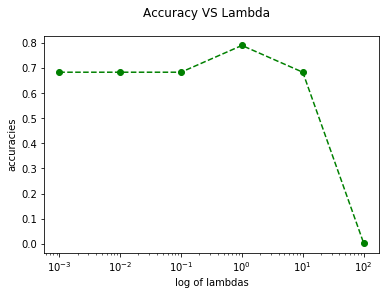

In [13]:
plt.plot([0.001, 0.01, 0.1, 1, 10, 100], accuracies, '--go')
plt.suptitle('Accuracy VS Lambda')
plt.xlabel('log of lambdas')
plt.ylabel('accuracies')
plt.xscale('log')
plt.show()

As you can see from the above graph, there is a sweet spot for the regularization constant to get maximum accuracy. From testing, we found that a lambda value of 1 lead to a peak in our accuracy. 

However, it is important to note that due to time constraints the maximum number of iterations each lambda could be done was 10. This probably meant that for lower values of lambda there wasn't enough iterations in order to see the real difference in accuracy between these values. This lead to a accuracy that was roughly constant in the lower lambda range (lambda < 1) and as our regularization constant grew past 1 the accuracy dropped sharply. 

In the future, with more computational power we'd be interested in getting a higher resolution version of the above graph where we are able to test more lambdas in a smaller range around the peak value of 1. Overall, it is worth noting, the accuracy at each regularization apart from 100 was pretty good with values around 70%+.

In [14]:
pd.DataFrame(model_lr.cm_accuracy(X_test, y_test)[0])

/Users/clou/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


,0,1,2,3,4,5,6,7,8,9
0,906,0,18,6,5,26,24,9,5,12
1,0,882,1,0,0,2,2,8,0,1
2,4,2,792,21,6,8,25,16,3,16
3,0,2,29,788,1,98,1,0,17,10
4,0,0,16,0,812,11,11,16,4,231
5,3,0,0,19,0,454,14,0,2,6
6,15,5,27,9,24,20,836,1,5,4
7,1,0,7,7,1,6,0,854,4,66
8,51,244,142,158,122,264,45,115,934,267
9,0,0,0,2,11,3,0,9,0,396


When it comes to the confusion matrix you see above it is worth first noting the the row's indicate that the actual image is the index of the row. For instance, the 5th row shows the predictions when the image is ACTUALLY a 5. The columns indicate what value was predicted for a given row. So the 3rd row, 4th column would be the number of times the image was actually a 2 but was predicted to be a 3. 
Also worth noting, this confusion matrix was generated for a regularization constant of 1 because this lambda led to the highest overall accuracy.

As you can see the majority of predictions matched that of the image, this is shown by the diagonal of the matrix having larger values than any non diagonal entry. Interestingly, for images of the digit 8 the algorithm had a very hard time predicting these images. This can be seen by how in the 9th row there are many large values for each column. Basically saying that the image 8 was misclassified not only frequently, but was misclassified as each other number. So it's safe to say that our algorithm had no idea what to do with images of 8.

In [15]:
pd.DataFrame(model_lr.cm_accuracy(X_test, y_test)[1], columns=["accuracy"])

/Users/clou/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


,accuracy
0,0.89614
1,0.98438
2,0.88690
3,0.83298
4,0.73751
5,0.91165
6,0.88372
7,0.90275
8,0.39880
9,0.94062


You can see the actual accuracies of each digit in the above table. Our most accurately classified digit was a 1 while the worst was an 8. This was in contrast to the naive bayes classifier where the most accurate digit was a 2 while the worst was still an 8. It is worth noting though that the Knn classifier had a similar problem with classifying 8. So it's safe to say that, for most classifiers, the digit 8 is a hard digit for most algorithms to guess.

/Users/clou/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


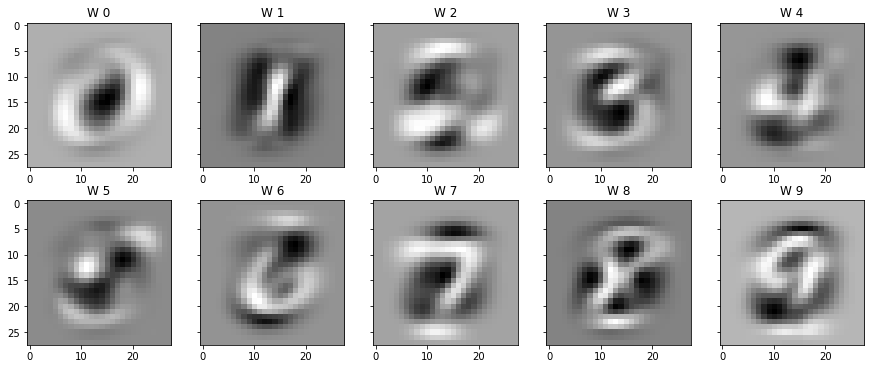

In [16]:
w_set = model_lr.weights(X_train, y_train, lam=1)

f, axs = plt.subplots(2, 5,figsize=(15, 6), sharey=True)
axs = axs.ravel()
for i in range(len(w_set)):
    axs[i].imshow(w_set[i][1:].reshape(28,28),cmap=plt.cm.gray)
    axs[i].set_title('W %s'%i)

When we go through and plot the actual values of our W it's pretty clear that for each W we can tell what number is being represented. The only exceptions to this would be the digit 5 and 2, at least to me both of those digits are hard to tell from the above image. 

Part of the reason why I believe that 8 has so much trouble classifying images is because the digit 8 puts priority on the same pixels as the number 1, 3, 5, and 9. This is due to in the image the brighter pixels were the same in each of those digits. We can also see this within the confusion matrix, as the majority of the misclassifications for the images of the digit 8 happened to be 1's, 3's, 5's, and 9's. 